In [1]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
meta_activity_map_file = "/data5/deepro/starrseq/papers/results/1_categorize_fragments_on_activity/data/meta_activity_map.csv"
de_gene_dir = "/data5/deepro/starrseq/papers/results/4_compare_expression_ko_vs_wt/data/results/de"
da_to_de_dir = "/data5/deepro/starrseq/papers/results/5_link_da_enhancers_to_de_genes/data/da_enhancers_to_de_genes_links"
gtf_file = "/data5/deepro/starrseq/papers/results/5_link_da_enhancers_to_de_genes/data/genome_annot/parsed_gtf.tsv"
save_dir = "/data5/deepro/starrseq/papers/results/5_link_da_enhancers_to_de_genes/data/da_enhancers_to_de_genes_links"
libraries = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [4]:
meta_df = pd.read_csv(meta_activity_map_file)
gtf_df = pd.read_csv(gtf_file, sep="\t", header=None)
target_gene_id_to_gene_dict = dict(zip(gtf_df[3], gtf_df[4]))

In [5]:
def plot_diff_activity_map(plot_df, libn, coords_to_mark):
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    plot_df[f"{libn}_padj"] = plot_df[f"{libn}_padj"].fillna(1.)
    sns.lineplot(data=plot_df, x=plot_df.index, y="CC", ax=axes, linewidth=2.5, alpha=0.75)

    size_list = -np.log(plot_df[f"{libn}_padj"])/2
    style_list = [] 
    for lfc, padj in zip(plot_df[f"{libn}_log2FoldChange"], plot_df[f"{libn}_padj"]):
        if (lfc>0 and padj<0.01):
            style_list.append("induced")
        elif (lfc<0 and padj<0.01):
            style_list.append("repressed")
        else:
            style_list.append("unresponsive")
    sns.scatterplot(    
        data=plot_df, x=plot_df.index, y=libn, ax=axes, 
        size=size_list, 
        hue=style_list, hue_order=["unresponsive", "induced",  "repressed"], palette={"induced": "darkgreen", "repressed": "darkred", "unresponsive": "slategray"},
        style=style_list, style_order=["unresponsive", "induced",  "repressed"], markers={"induced": "^", "repressed": "v", "unresponsive": "o"}, 
        legend=False, rasterized=True)
    # no x tick labels
    axes.set_xticks([])
    axes.set_xticklabels([])
    # y label ticks needed
    axes.yaxis.set_tick_params(width=2, length=5, which="major")
    axes.yaxis.get_label().set_visible(False)
    axes.set_title(libn)
    axes.yaxis.set_major_locator(MultipleLocator(2))
    # draw a line at 
    axes.axhline(0, color ='black', lw = 2, alpha = 0.5)
    # remove spines
    axes.spines[["right", "top", "bottom"]].set_visible(False)

    xcoord_shift = 0.25
    ycoord_shift = 0.25
    y_coord = max(plot_df[libn]) + ycoord_shift
    x_coord = max(plot_df.index) + xcoord_shift

    annot_df = plot_df.loc[plot_df.chrom_coord.isin(coords_to_mark)]
    annot = annot_df.chrom_coord.values
    annot_x = list(annot_df.index)
    annot_y = annot_df[libn].values
    annot_xtext = [x_coord for i in range(len(annot_x))]
    annot_ytext = []
    for i in range(len(annot_y)):
        annot_ytext.append(y_coord)
        y_coord -= axes.get_ylim()[1]//5
    print(annot_ytext)

    for i in range(len(annot_y)):
        axes.annotate(
            annot[i], 
            xy=(annot_x[i], annot_y[i]), xytext=(annot_xtext[i], annot_ytext[i]), 
            arrowprops={"arrowstyle": "->", "lw": 1, "color": "black", "ls": "--", "relpos": (0,0.5)}, 
            fontsize=12)
    return fig, axes

def parse_deseqres_for_volcano_plot(df):
    # drop rows with na values
    df = df.dropna()
    # convert all 0 padj values to a tenth of the min padj value thats greater than 0
    df.loc[df.padj==0, "padj"] = min(df.loc[df.padj>0].padj)/10
    # create neglog10 val
    df["neglog10padj"] = -np.log10(df.padj)
    # create hue columns
    lfc_thresh = 0.5
    pv_thresh = 0.01
    df["hue"] = "Not Significant"
    df.loc[(df.log2FoldChange>lfc_thresh)&(df.padj<pv_thresh), "hue"] = "Significant Up"
    df.loc[(df.log2FoldChange<-lfc_thresh)&(df.padj<pv_thresh), "hue"] = "Significant Down"
    return df

def create_volcano_fig_raw(df_volcano, lfc_thresh=0.5, pv_thresh=0.01, gene_set=[]):

    if len(gene_set)<1:
        gene_set = df_volcano.sort_values("padj").head().gene_name.values

    fig, axes = plt.subplots(1, 1, figsize=(6, 8))
    sns.scatterplot(
        data=df_volcano, x="log2FoldChange", y="neglog10padj", 
        hue="hue", palette={"Significant Down": "red", "Not Significant": "grey", "Significant Up": "green"},
        ax=axes, s=2,
        legend=False,
        )
    axes.axvline(x=lfc_thresh, linestyle="--", color="k")
    axes.axvline(x=-lfc_thresh, linestyle="--", color="k")
    axes.axhline(y=-np.log10(pv_thresh), linestyle="--", color="k")

    xcoord_shift = 0.25
    ycoord_shift = 0.25
    y_coord = max(df_volcano.neglog10padj) + ycoord_shift
    x_coord = max(df_volcano.log2FoldChange) + xcoord_shift

    for info in df_volcano.loc[df_volcano.gene_name.isin(gene_set)].itertuples():
        axes.annotate(
            info.gene_name, 
            xy=(info.log2FoldChange, info.neglog10padj), xytext=(x_coord, y_coord), 
            arrowprops={"arrowstyle": "->", "lw": 1, "color": "black", "ls": "--", "relpos": (0,0.5)}, 
            fontsize=12)
        y_coord -= axes.get_ylim()[1]//20 # division by 20 needs to be edited to fit the limits correctly

    axes.set_xlim(axes.get_xlim()[0], axes.get_xlim()[1]+ xcoord_shift + axes.get_xlim()[1]/20)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.collections[0].set_rasterized(True)
    return fig


[6.551419680436233, 5.551419680436233, 4.551419680436233, 3.551419680436233, 2.551419680436233, 1.5514196804362328, 0.5514196804362328, -0.4485803195637672]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

[5.042427340499519, 4.042427340499519, 3.0424273404995192, 2.0424273404995192, 1.0424273404995192, 0.04242734049951924, -0.9575726595004808, -1.9575726595004808, -2.9575726595004808]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

[6.145065263583568, 5.145065263583568, 4.145065263583568, 3.145065263583568, 2.145065263583568, 1.145065263583568, 0.14506526358356808, -0.8549347364164319, -1.854934736416432, -2.854934736416432]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

[5.9588109739558845, 4.9588109739558845, 3.9588109739558845, 2.9588109739558845, 1.9588109739558845, 0.9588109739558845, -0.04118902604411545, -1.0411890260441155, -2.0411890260441155, -3.0411890260441155]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

[5.963423077884083, 4.963423077884083, 3.963423077884083, 2.963423077884083, 1.9634230778840829, 0.9634230778840829, -0.03657692211591712, -1.0365769221159171, -2.036576922115917, -3.036576922115917]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

[6.128861241061313, 5.128861241061313, 4.128861241061313, 3.128861241061313, 2.128861241061313, 1.1288612410613128, 0.1288612410613128, -0.8711387589386872, -1.8711387589386872, -2.871138758938687]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

[5.532976926782416, 4.532976926782416, 3.532976926782416, 2.532976926782416, 1.5329769267824158, 0.5329769267824158, -0.4670230732175842, -1.4670230732175842, -2.467023073217584, -3.467023073217584]


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_3065947/122671520.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neglog10padj"] = -np.log10(df.padj)
/tmp/ipykernel_3065947/122671520.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

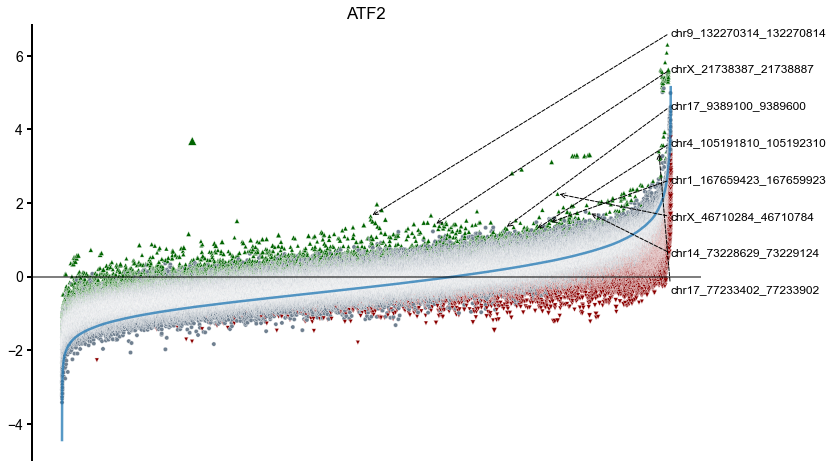

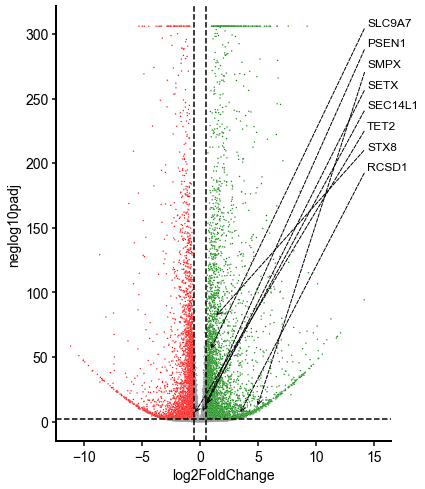

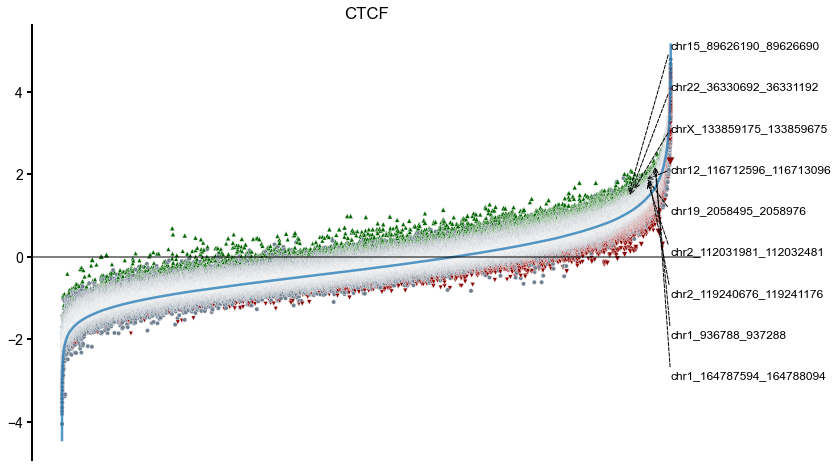

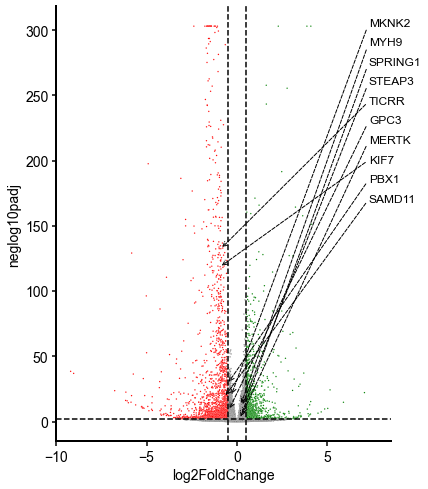

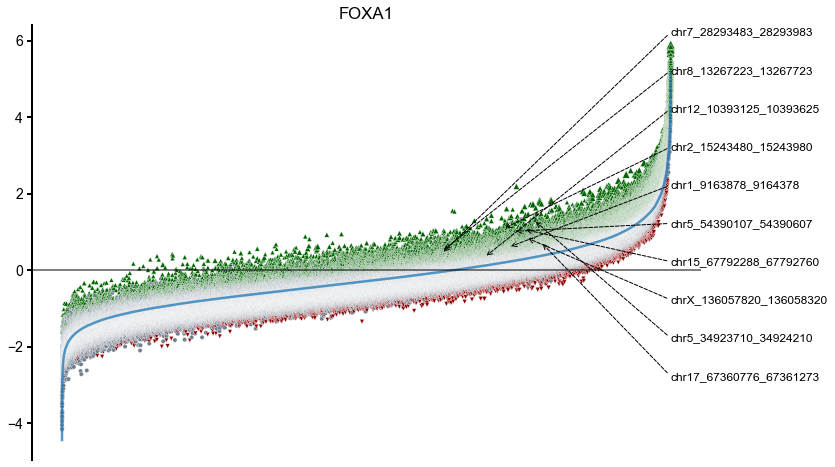

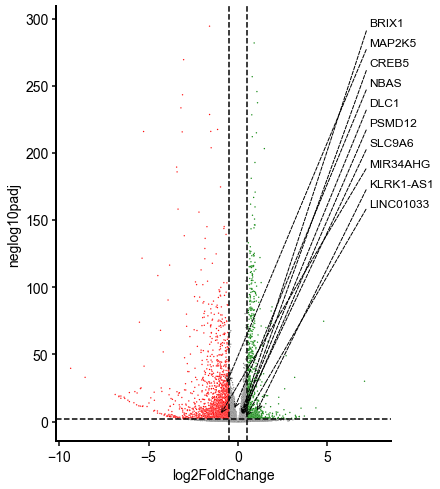

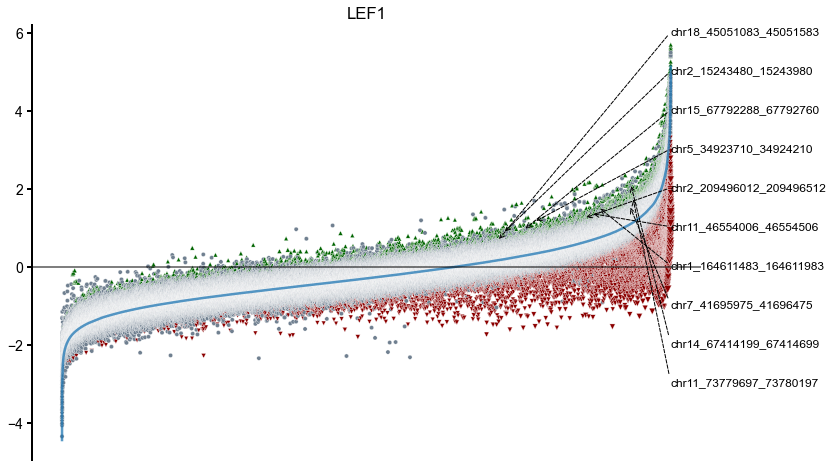

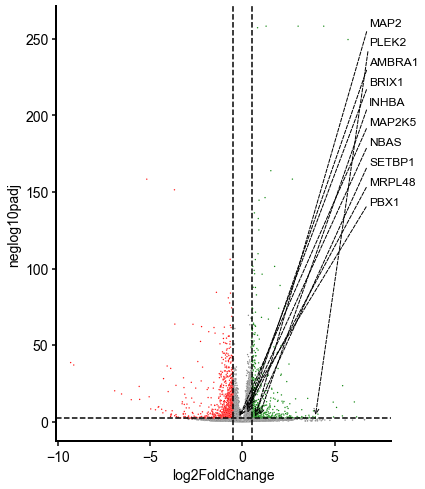

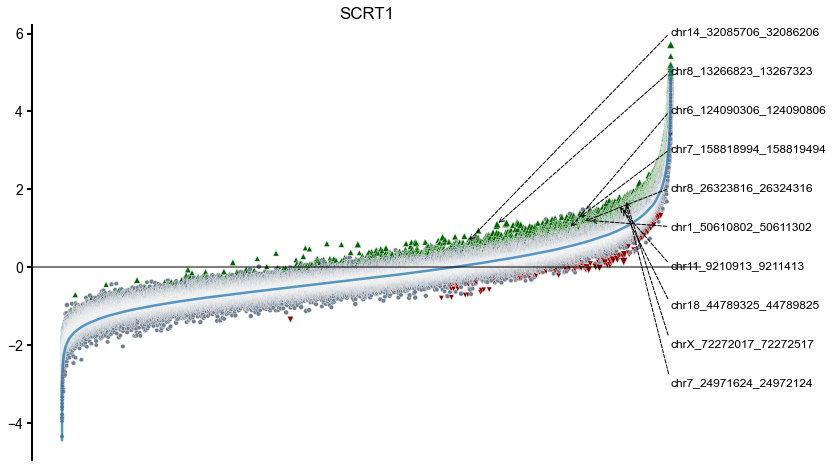

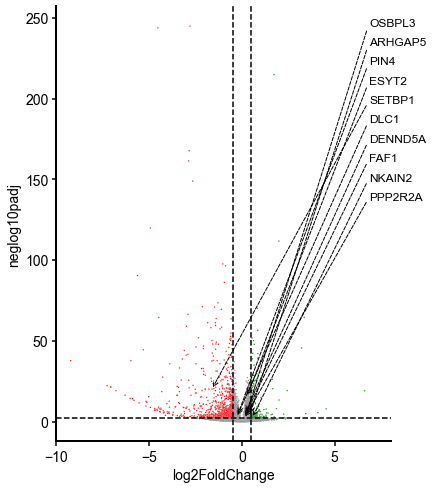

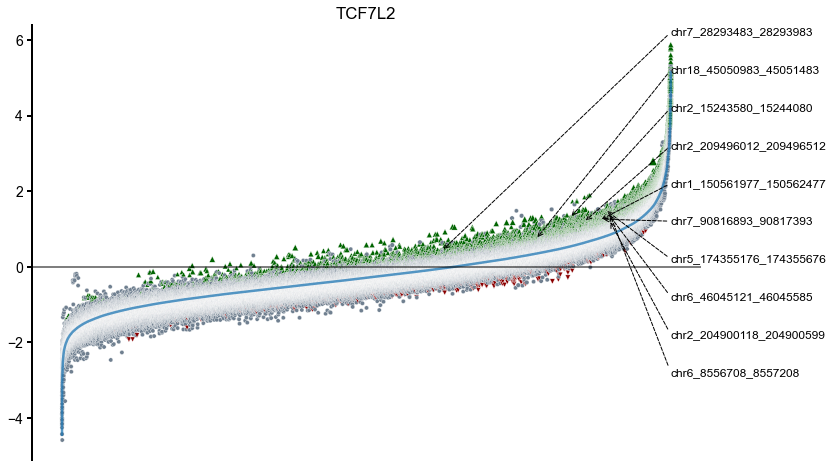

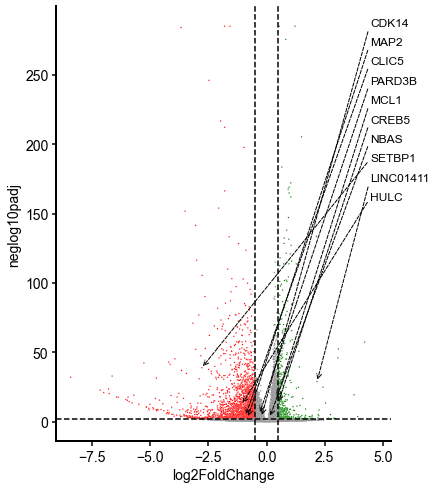

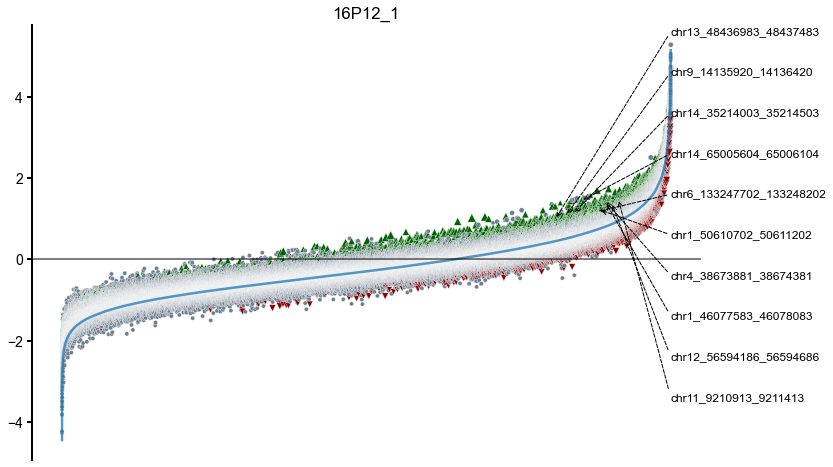

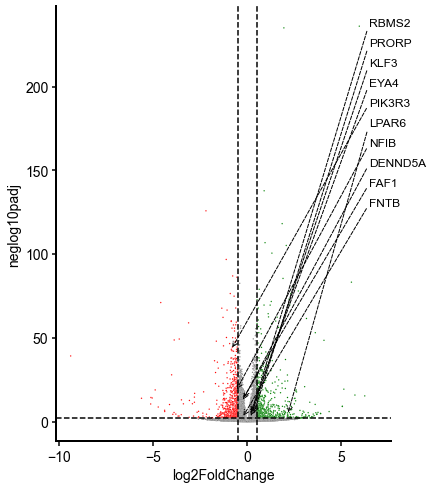

In [6]:
for ko in libraries[1:]:
    de_file = os.path.join(de_gene_dir, f"{ko}vsCC", "de_results.csv")
    de_df = pd.read_csv(de_file)
    de_df["gene_name"] = de_df.index.map(target_gene_id_to_gene_dict)
    da_to_de_gained_file = os.path.join(da_to_de_dir, ko, "gained_frag_nearest_target_sde.csv")
    gained_df = pd.read_csv(da_to_de_gained_file).drop_duplicates("target_gene_nearest")
    gained_coords = gained_df.chrom_coord.values[:10]
    gained_tgs = gained_df.target_gene_nearest.values[:10]
    da_to_de_lost_file = os.path.join(da_to_de_dir, ko, "lost_frag_nearest_target_sde.csv")
    lost_df = pd.read_csv(da_to_de_lost_file)
    lost_coords = lost_df.chrom_coord.values[:10]
    lost_tgs = lost_df.target_gene_nearest.values[:10]
    diff_fig, diff_axes =  plot_diff_activity_map(meta_df, ko, gained_coords)
    save_pdf(os.path.join(save_dir, ko, "da_link_fig.pdf"), diff_fig)
    deseq_parsed = parse_deseqres_for_volcano_plot(de_df)
    vfig = create_volcano_fig_raw(deseq_parsed, gene_set=gained_tgs)
    save_pdf(os.path.join(save_dir, ko, "de_link_fig.pdf"), vfig)